# ECS Modeling (ECS_MD)

이 노트북은 머신러닝 모델링 단계로, 전처리가 완료된 데이터를 사용하여 다양한 모델을 학습하고 성능을 비교합니다.
ML Modeler: 모델 구축, 튜닝, 평가 담당

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# AutoGluon 설치 필요 (pip install autogluon)
try:
    from autogluon.tabular import TabularDataset, TabularPredictor
    AUTOGLUON_AVAILABLE = True
except ImportError:
    AUTOGLUON_AVAILABLE = False
    print('AutoGluon is not installed. Skipping AutoGluon steps.')

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 로드 (ECS_FE에서 생성된 데이터 가정)
# 실제 파일 실행 전 ECS_FE.ipynb를 실행하여 Train_FE.csv를 생성해야 합니다.
try:
    df = pd.read_csv('./data/Train_FE.csv')
    print('Data Loaded:', df.shape)
except FileNotFoundError:
    print('Error: Train_FE.csv not found. Please run ECS_FE.ipynb first.')
    # Fallback for demonstration if file doesn't exist immediately
    # df = pd.read_csv('./data/Train.csv') # This would fail without FE, so just stopping here.
    df = None

Data Loaded: (10999, 26)


## 2. 데이터 분할 (Train/Test Split)
모델 성능 검증을 위해 데이터를 학습용과 테스트용으로 나눕니다.

In [9]:
if df is not None:
    X = df.drop(columns=['Reached.on.Time_Y.N'])
    y = df['Reached.on.Time_Y.N']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print('Train Shape:', X_train.shape)
    print('Test Shape:', X_test.shape)

Train Shape: (8799, 25)
Test Shape: (2200, 25)


## 3. Baseline Models
- **Logistic Regression**: 선형 모델 기준
- **Random Forest**: 앙상블 모델 기준

In [10]:
if df is not None:
    # Logistic Regression
    lr = LogisticRegression(random_state=42)
    lr.fit(X_train, y_train)
    pred_lr = lr.predict(X_test)
    prob_lr = lr.predict_proba(X_test)[:, 1]
    print('Logistic Regression Accuracy:', accuracy_score(y_test, pred_lr))
    print('Logistic Regression ROC-AUC:', roc_auc_score(y_test, prob_lr))

    # Random Forest
    rf = RandomForestClassifier(random_state=42, n_estimators=100)
    rf.fit(X_train, y_train)
    pred_rf = rf.predict(X_test)
    prob_rf = rf.predict_proba(X_test)[:, 1]
    print('Random Forest Accuracy:', accuracy_score(y_test, pred_rf))
    print('Random Forest ROC-AUC:', roc_auc_score(y_test, prob_rf))

Logistic Regression Accuracy: 0.6831818181818182
Logistic Regression ROC-AUC: 0.747308804247869
Random Forest Accuracy: 0.6622727272727272
Random Forest ROC-AUC: 0.7295727144477522


## 4. Boosting Models
- **XGBoost**
- **LightGBM**

In [11]:
if df is not None:
    # XGBoost
    xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    xgb.fit(X_train, y_train)
    pred_xgb = xgb.predict(X_test)
    prob_xgb = xgb.predict_proba(X_test)[:, 1]
    print('XGBoost Accuracy:', accuracy_score(y_test, pred_xgb))
    print('XGBoost ROC-AUC:', roc_auc_score(y_test, prob_xgb))

    # LightGBM
    lgbm = LGBMClassifier(random_state=42)
    lgbm.fit(X_train, y_train)
    pred_lgbm = lgbm.predict(X_test)
    prob_lgbm = lgbm.predict_proba(X_test)[:, 1]
    print('LightGBM Accuracy:', accuracy_score(y_test, pred_lgbm))
    print('LightGBM ROC-AUC:', roc_auc_score(y_test, prob_lgbm))

XGBoost Accuracy: 0.6472727272727272
XGBoost ROC-AUC: 0.7348147181381914
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5250, number of negative: 3549
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1102
[LightGBM] [Info] Number of data points in the train set: 8799, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596659 -> initscore=0.391562
[LightGBM] [Info] Start training from score 0.391562
LightGBM Accuracy: 0.6659090909090909
LightGBM ROC-AUC: 0.7358562497477743


## 5. AutoGluon (AutoML)
자동화된 머신러닝을 통해 최적의 모델과 앙상블을 찾습니다.

In [12]:
if df is not None and AUTOGLUON_AVAILABLE:
    # AutoGluon 데이터 포맷
    train_data = pd.concat([X_train, y_train], axis=1)
    test_data = pd.concat([X_test, y_test], axis=1)
    label = 'Reached.on.Time_Y.N'

    # 학습
    predictor = TabularPredictor(label=label, eval_metric='roc_auc').fit(train_data, presets='best_quality')

    # 리더보드 확인
    leaderboard = predictor.leaderboard(test_data)
    print(leaderboard.head())

    # 최적 모델 평가
    y_pred_ag = predictor.predict(X_test)
    y_prob_ag = predictor.predict_proba(X_test).iloc[:, 1]  # 확률값 추출
    print('AutoGluon Accuracy:', accuracy_score(y_test, y_pred_ag))
    print('AutoGluon ROC-AUC:', roc_auc_score(y_test, y_prob_ag))

No path specified. Models will be saved in: "AutogluonModels\ag-20260204_040650"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.11.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          14
Pytorch Version:    2.9.1+cpu
CUDA Version:       CUDA is not available
Memory Avail:       15.98 GB / 31.53 GB (50.7%)
Disk Space Avail:   98.64 GB / 212.20 GB (46.5%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	

                        model  score_test  score_val eval_metric  \
0         CatBoost_r69_BAG_L1    0.751842   0.743785     roc_auc   
1          CatBoost_r5_BAG_L1    0.751470   0.745762     roc_auc   
2          XGBoost_r31_BAG_L1    0.751062   0.744919     roc_auc   
3  NeuralNetTorch_r121_BAG_L1    0.751009   0.741088     roc_auc   
4         CatBoost_r49_BAG_L1    0.750850   0.745084     roc_auc   

   pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  \
0        0.025560       0.028490    6.733803                 0.025560   
1        0.037394       0.032414    6.523422                 0.037394   
2        0.186063       0.182302    4.031154                 0.186063   
3        5.715594       0.896911  202.823316                 5.715594   
4        0.034847       0.017703    5.298273                 0.034847   

   pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  \
0                0.028490           6.733803            1       True   
1       

## 6. Feature Importance
모델이 어떤 변수를 중요하게 생각하는지 시각화하여 비즈니스 인사이트를 도출합니다 (XGBoost 기준).

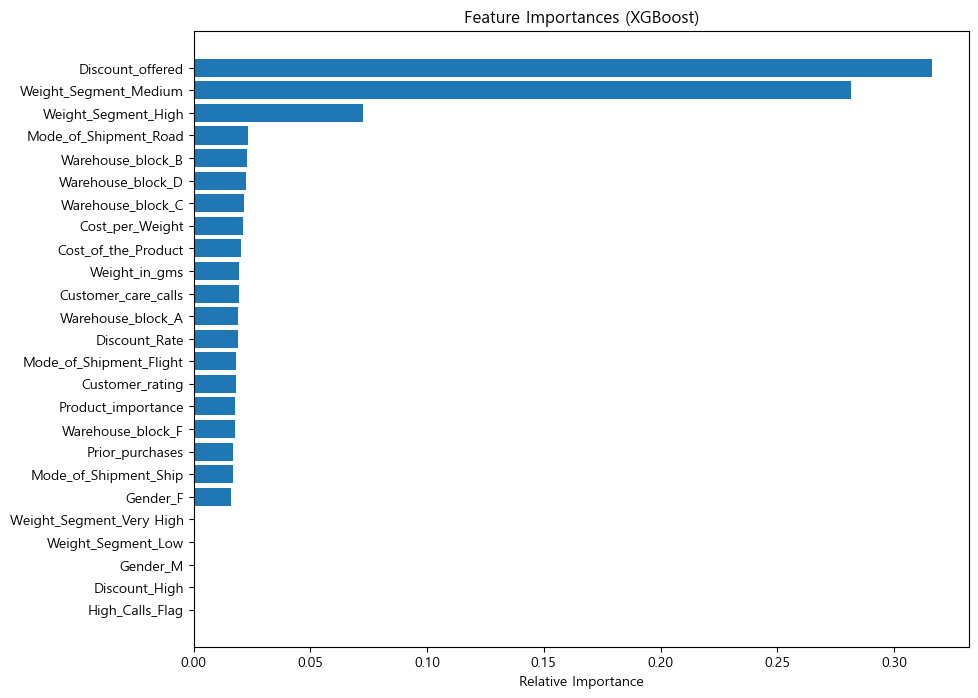

In [13]:
if df is not None:
    plt.figure(figsize=(10, 8))
    # XGBoost Feature Importance
    importances = xgb.feature_importances_
    indices = np.argsort(importances)[::-1]
    columns = X.columns

    plt.title('Feature Importances (XGBoost)')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [columns[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.gca().invert_yaxis() # 상위 중요도가 위로 오게
    plt.show()